In [59]:
import numpy as np
import pandas as pd
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
%matplotlib inline

## 1. Data Preparation

In [32]:
data = pd.read_excel('../data/Testcase_dataset-IBPEM.xlsx')
# Create timestamp from two columns
data['timestamp'] = pd.to_datetime({
    'year': data['Date'].str.split('-').str.get(0), 
    'month': data['Date'].str.split('-').str.get(1), 
    'day': data['Date'].str.split('-').str.get(2), 
    'hour':data['Time'].str.slice(0, 2), 
    'minute': data['Time'].str.slice(2,4)})

data = data.drop(columns=['Date', 'Time'])
data = data.set_index('timestamp')

# Let's take only the CWRT_syth first
series1 = data['CWRT_syth'].dropna()

In [33]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)
        y.append(seq_x)
    return array(X), array(y)

In [40]:
# define input sequence
raw_seq = series1.to_list()
# choose a number of time steps
n_steps = 36
# split into samples
X, y = split_sequence(raw_seq, n_steps)

## 2. Autoencoder model

In [41]:
# returns train, inference_encoder and inference_decoder models
def define_models(n_input, n_units):
    # define training encoder
    encoder_inputs = Input(shape=(None, n_input))
    encoder = Dense(n_units, activation='relu')
    encoder_output = encoder(encoder_input)
    # define training decoder
    decoder_inputs = Input(shape=(None, n_units))
    decoder = Dense(n_inputs, activation='relu')
    decoder_outputs = decoder(decoder_inputs)
    model = Model(encoder_inputs, decoder_outputs)
    
    # return all models
    return model

In [42]:
# configure problem
n_inputs = 36
n_units = 6
# define model
# define model
autoencoder_model = Sequential()
autoencoder_model.add(Dense(n_units, activation='relu', input_shape=(n_inputs,)))
autoencoder_model.add(Dense(n_inputs, activation='relu'))
autoencoder_model.compile(optimizer='adam', loss='mse')

In [43]:
# fit model
autoencoder_model.fit(X, y, epochs=20, verbose=1)

Epoch 1/20
17579/17579 [==============================] - 2s 107us/step - loss: 332.2711
Epoch 2/20
17579/17579 [==============================] - 1s 40us/step - loss: 204.9809
Epoch 3/20
17579/17579 [==============================] - 1s 38us/step - loss: 204.8686
Epoch 4/20
17579/17579 [==============================] - 1s 37us/step - loss: 204.7476
Epoch 5/20
17579/17579 [==============================] - 1s 38us/step - loss: 204.5492
Epoch 6/20
17579/17579 [==============================] - 1s 37us/step - loss: 204.3751
Epoch 7/20
17579/17579 [==============================] - 1s 37us/step - loss: 204.2981
Epoch 8/20
17579/17579 [==============================] - 1s 49us/step - loss: 204.2359
Epoch 9/20
17579/17579 [==============================] - 1s 44us/step - loss: 204.1782
Epoch 10/20
17579/17579 [==============================] - 1s 39us/step - loss: 204.1247
Epoch 11/20
17579/17579 [==============================] - 1s 38us/step - loss: 204.0750
Epoch 12/20
17579/17579 [====

## 3. Compute anomaly scores

In [53]:
yhat = autoencoder_model.predict(X[0].reshape(1, n_inputs))

In [57]:
yhat[0]-y[0]

array([ 10.4009819 ,   3.71089478,   0.79310989,   6.48626366,
         4.03771019,   6.79951744,  -5.05364037,  -5.73617363,
        -1.00689468,  -1.3927372 , -31.29999924,  -0.22376442,
        -0.40049896,  -3.87848854,  -4.03582115,   0.60072517,
         4.36873245,   0.79971542, -31.43000031,  -9.44616013,
        -0.6151123 ,  -7.97236252, -31.46999931, -15.57022858,
        13.82105732,  18.1293335 ,  12.53452301,  15.08059883,
         0.        ,  24.42043114,  -5.84381752, -31.63999939,
       -31.63999939,  -0.51646233,  -7.3908844 ,  -8.42570496])

In [60]:
def anomaly_scores(model, X, y):
    anomaly_scores = list()
    for i in range(len(X)):
        yhat = autoencoder_model.predict(X[i].reshape(1, n_inputs))
        score = np.sum(abs(yhat[0]-y[i]))
        
        anomaly_scores.append(score)
        
    return anomaly_scores

scores = anomaly_scores(model, X, y)

In [64]:
padding_scores = [0.0 for i in range(round(n_inputs/2))] + scores + [0.0 for i in range(round(n_inputs/2))]
result = pd.DataFrame({'value': raw_seq, 'score': padding_scores})

array([<matplotlib.axes._subplots.AxesSubplot object at 0xb2c2efa90>,
      dtype=object)

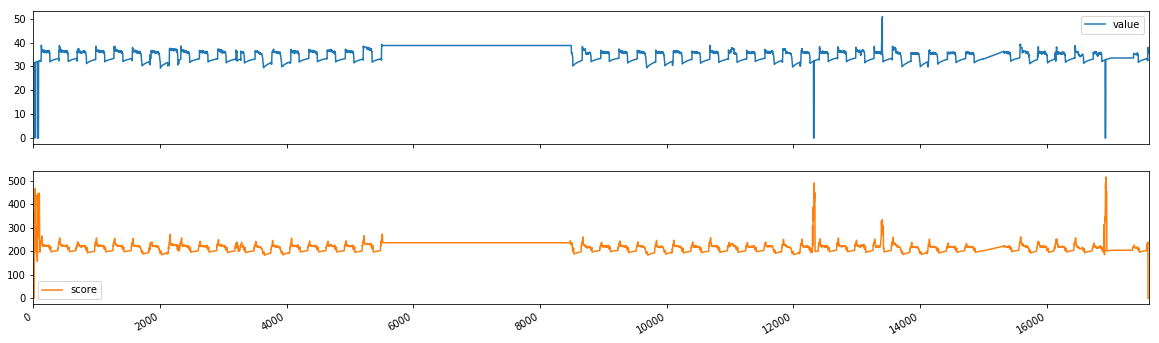

In [65]:
result.plot(figsize=[20,6], subplots=True)